# Taller 2 - CDA

In [1]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=960ff915ddbd71f784ba69576baba282bb326def91752dc984931854f068f3ff
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [3]:
df = pd.read_csv('apartamentos.csv')

In [4]:
print('Dimensiones del dataset (filas, columnas):', df.shape)
print('\nTipos de datos:')
print(df.dtypes)

Dimensiones del dataset (filas, columnas): (43013, 46)

Tipos de datos:
_id                         object
codigo                      object
tipo_propiedad              object
tipo_operacion              object
precio_venta               float64
area                       float64
habitaciones               float64
banos                      float64
administracion             float64
parqueaderos               float64
sector                      object
estrato                    float64
antiguedad                  object
latitud                    float64
longitud                   float64
direccion                   object
descripcion                 object
website                     object
last_view                   object
datetime                    object
url                         object
timeline                    object
estado                      object
compañia                    object
precio_arriendo            float64
jacuzzi                    float64
piso              

In [5]:
print('\nValores nulos por columna:')
print(df.isnull().sum())


Valores nulos por columna:
_id                            0
codigo                         0
tipo_propiedad                 0
tipo_operacion                 0
precio_venta               15429
area                           0
habitaciones                   1
banos                          1
administracion              7925
parqueaderos                   1
sector                      1641
estrato                        1
antiguedad                    10
latitud                        0
longitud                       0
direccion                  42219
descripcion                    0
website                        2
last_view                      2
datetime                       2
url                        42219
timeline                   13586
estado                       796
compañia                    4530
precio_arriendo            27184
jacuzzi                        2
piso                       43013
closets                    43013
chimenea                       2
permite_mascota

In [6]:
print('\nEstadísticas descriptivas:')
print(df.describe())


Estadísticas descriptivas:
       precio_venta          area  habitaciones         banos  administracion  \
count  2.758400e+04  4.301300e+04  43012.000000  43012.000000    3.508800e+04   
mean   2.364794e+09  1.800341e+02      2.615340      2.701339    4.059551e+06   
std    5.574198e+10  9.163002e+03      0.850046      1.196659    6.781642e+07   
min    1.000000e+06  0.000000e+00      1.000000      0.000000    1.000000e+00   
25%    4.029000e+08  6.300000e+01      2.000000      2.000000    3.490000e+05   
50%    7.000000e+08  1.000000e+02      3.000000      3.000000    6.500000e+05   
75%    1.330000e+09  1.740000e+02      3.000000      4.000000    1.200000e+06   
max    4.250000e+12  1.900000e+06      7.000000      6.000000    3.500000e+09   

       parqueaderos       estrato       latitud      longitud  \
count  43012.000000  43012.000000  43013.000000  43013.000000   
mean       1.662862      4.844648      4.686099    -74.062808   
std        1.114685      1.236190      0.038297

## Un poco de limpieza

In [4]:
p99 = df["precio_venta"].quantile(0.99)
df = df[df["precio_venta"] <= p99]

In [5]:
# solo los que tienen precio de venta con sentido, no creo que valga la pena meterle algún mean porque pierde la distribución natural de la variable
df = df[df['precio_venta'].notna()]

In [6]:
# totalmente vacías o redundantes
cols_to_drop = [
    '_id', 'codigo', 'direccion', 'url', 'website',
    'timeline', 'estado', 'compañia', 'piso', 'closets', 'descripcion', 'tipo_operacion', 'estacion_tm_cercana', "parque_cercano", "antiguedad", "barrio"
]
df = df.drop(columns=cols_to_drop, errors='ignore')

In [7]:
# fechas
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
df['last_view'] = pd.to_datetime(df['last_view'], errors='coerce')

In [8]:
# bools
bool_cols = [
    'jacuzzi','chimenea','permite_mascotas','gimnasio',
    'ascensor','conjunto_cerrado','piscina','salon_comunal',
    'terraza','vigilancia','is_cerca_estacion_tm','is_cerca_parque'
]
for c in bool_cols:
    df[c] = df[c].fillna(0).astype(bool)

In [9]:
# mediana en estrado
df['administracion'] = df.groupby('estrato')['administracion'].transform(
    lambda x: x.fillna(x.median())
)

In [10]:
# nulos que quedan
df = df.dropna(subset=['estrato', 'sector', 'localidad'])

In [11]:
cols_to_drop = ["precio_arriendo"]
df = df.drop(columns=cols_to_drop, errors='ignore')

In [15]:
df.shape

(26537, 29)

## Revisión de distribución de la variable objetivo "precio_venta"

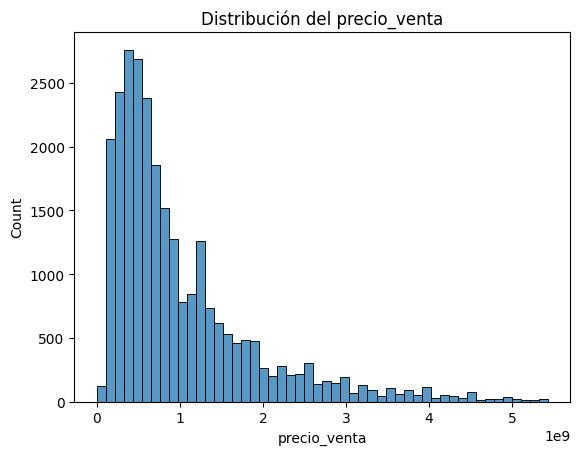

In [16]:
sns.histplot(df['precio_venta'], bins=50)
plt.title("Distribución del precio_venta")
plt.show()

## Relación precio_venta con demás variables

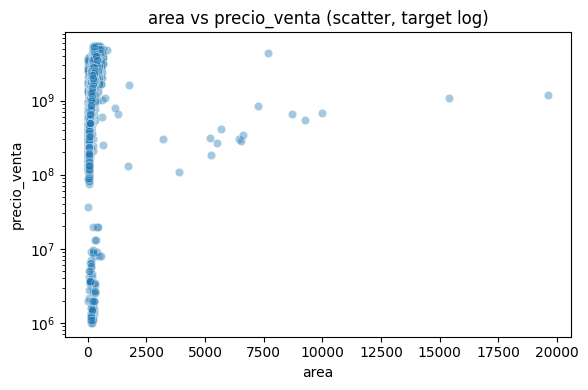

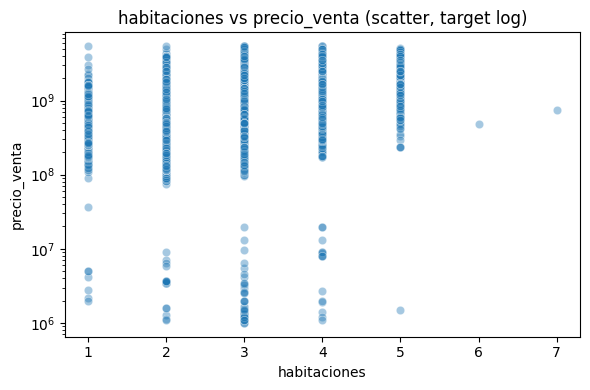

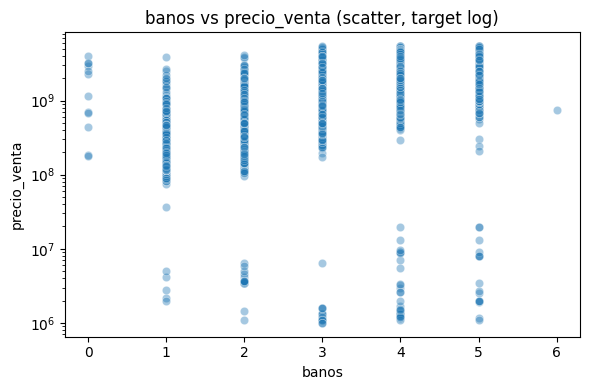

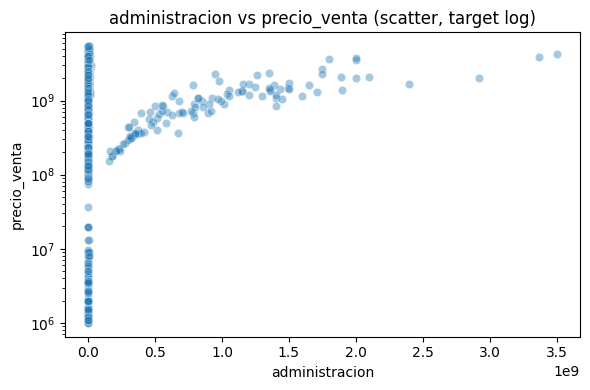

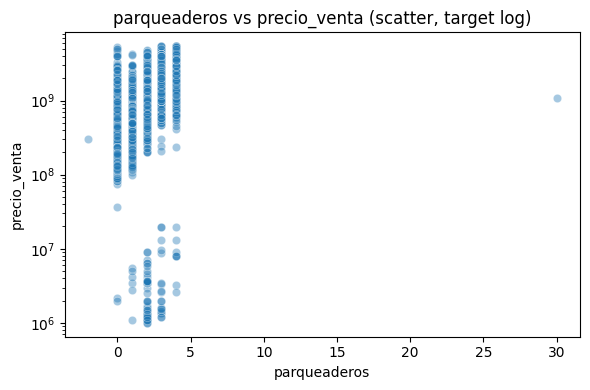

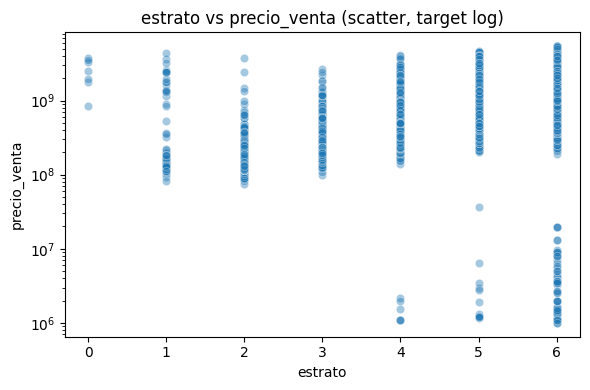

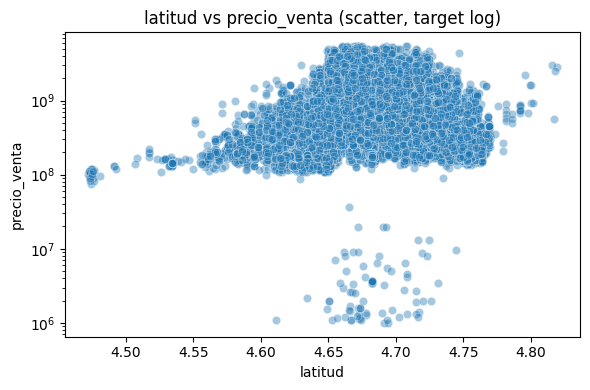

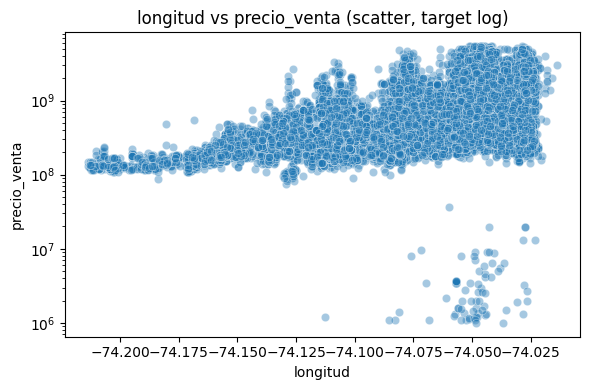

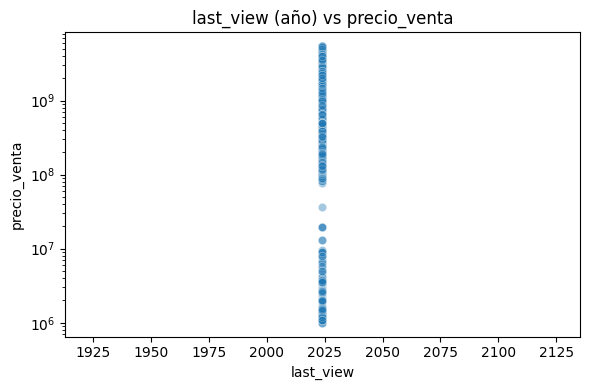

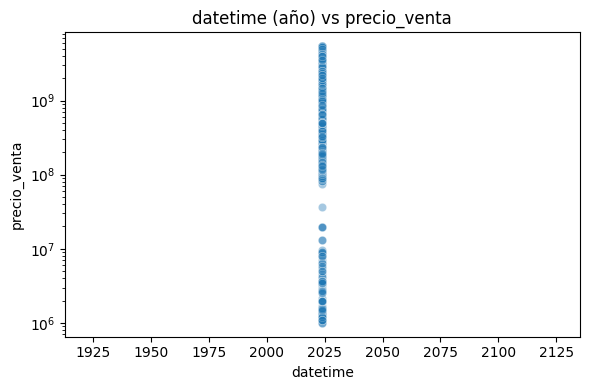

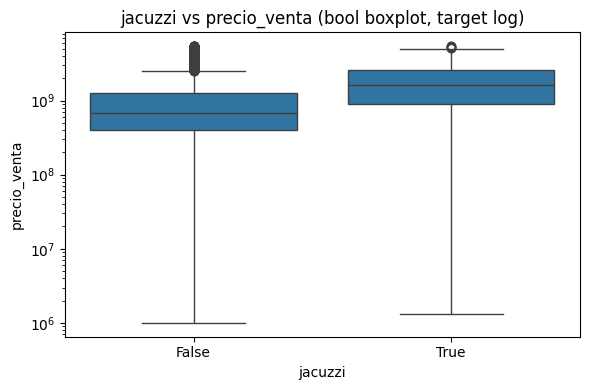

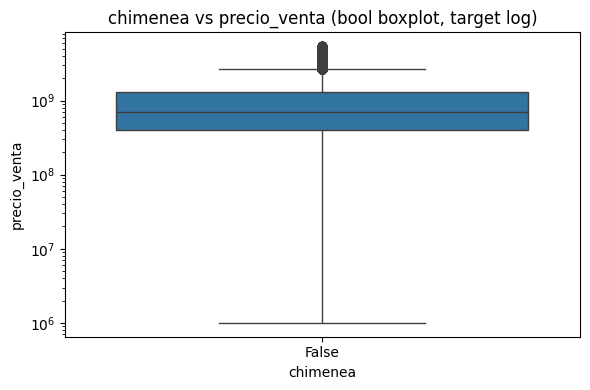

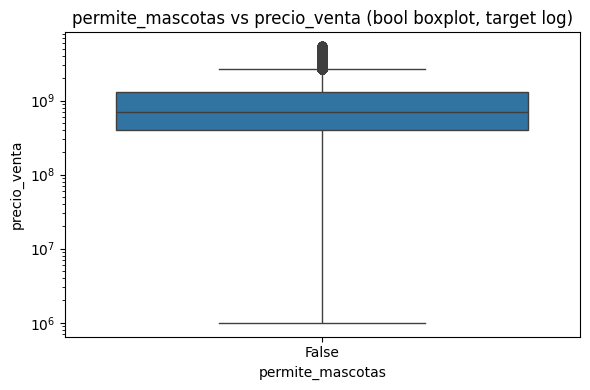

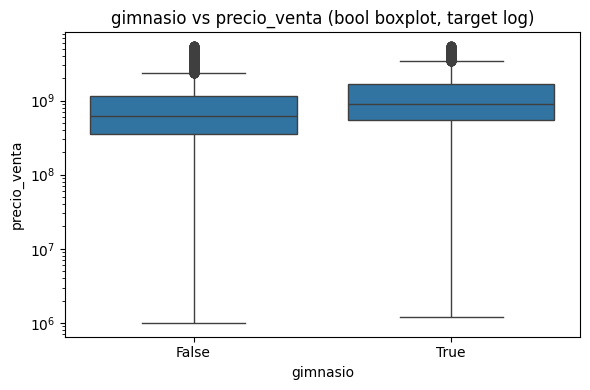

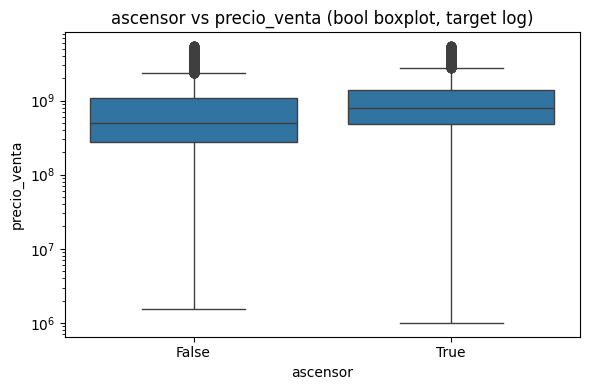

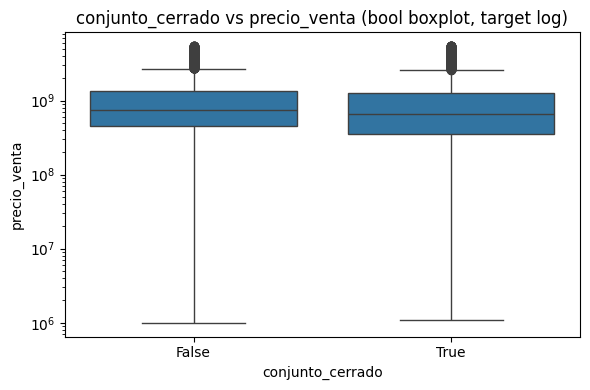

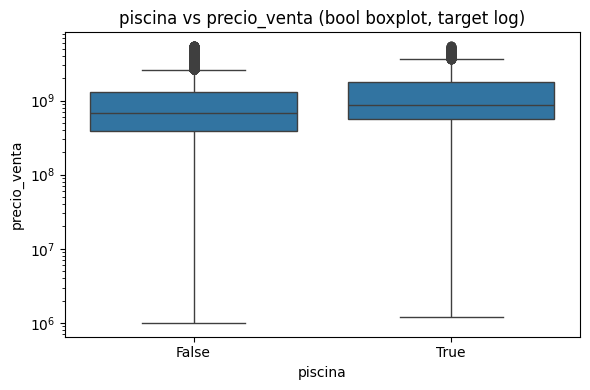

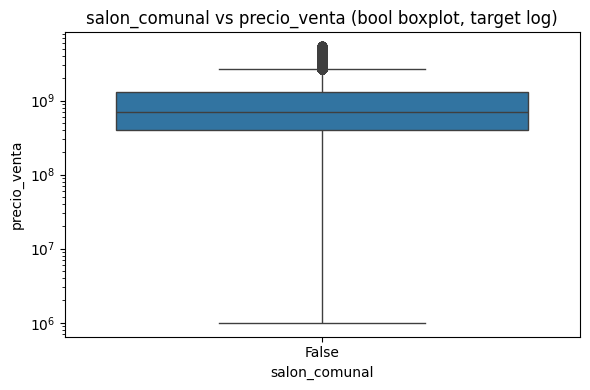

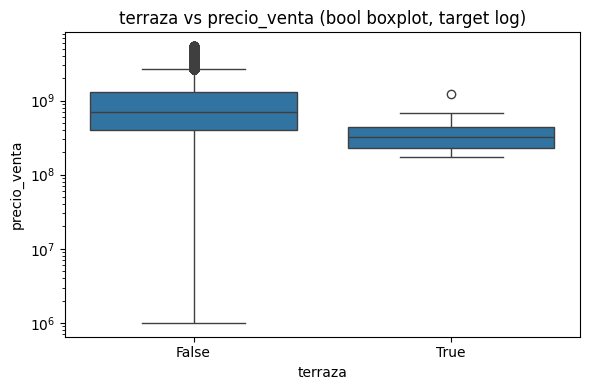

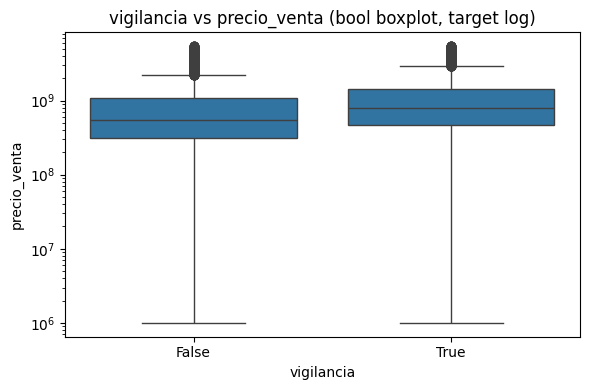

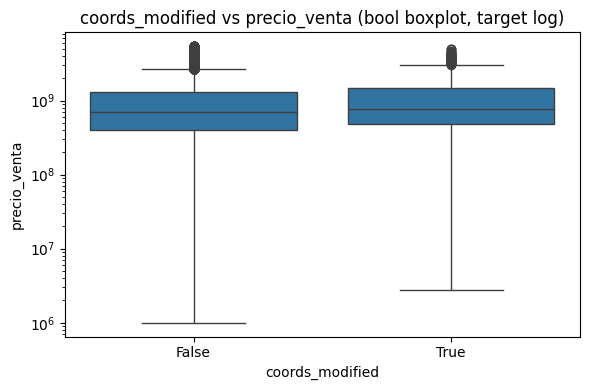

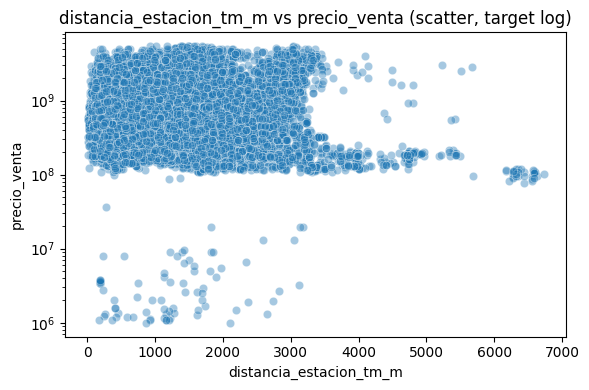

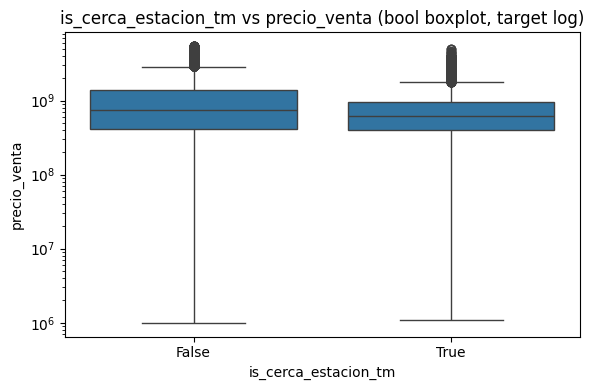

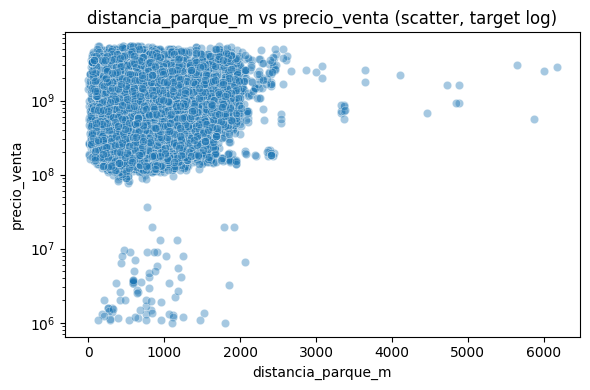

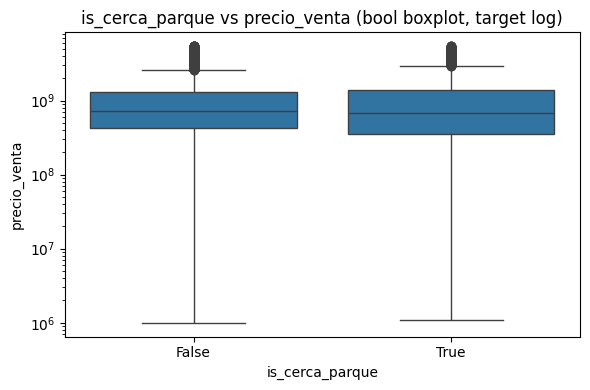

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

target = "precio_venta"

for col in df.columns:
    if col == target:
        continue

    plt.figure(figsize=(6,4))

    # ============================
    # 1) Variables numéricas
    # ============================
    if np.issubdtype(df[col].dtype, np.number):
        sns.scatterplot(data=df, x=col, y=target, alpha=0.4)
        plt.yscale("log")
        plt.title(f"{col} vs {target} (scatter, target log)")

    # ============================
    # 2) Variables categóricas
    # ============================
    elif df[col].dtype.name == "category":
        # Limitar categorías muy grandes
        if df[col].nunique() <= 20:
            sns.boxplot(data=df, x=col, y=target)
            plt.yscale("log")
            plt.title(f"{col} vs {target} (boxplot, target log)")
            plt.xticks(rotation=45)
        else:
            plt.close()
            continue

    # ============================
    # 3) Variables booleanas
    # ============================
    elif df[col].dtype == bool:
        sns.boxplot(data=df, x=col, y=target)
        plt.yscale("log")
        plt.title(f"{col} vs {target} (bool boxplot, target log)")

    # ============================
    # 4) Variables datetime
    # ============================
    elif np.issubdtype(df[col].dtype, np.datetime64):
        # Usar solo el año
        sns.scatterplot(data=df, x=df[col].dt.year, y=target, alpha=0.4)
        plt.yscale("log")
        plt.title(f"{col} (año) vs {target}")

    else:
        plt.close()
        continue

    plt.tight_layout()
    plt.show()

## Modelos

In [12]:
categoricas = ["habitaciones", "banos", "estrato", "parqueaderos"]

numericas = [
    "area",
    "administracion",
    "latitud",
    "longitud"
]


In [13]:
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categoricas),
    ("num", StandardScaler(), numericas)
])

In [14]:
X = df[categoricas + numericas].copy()
y = df["precio_venta"]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
modelos = {
    "Regresión Lineal": LinearRegression(),
    "Árbol de Decisión": DecisionTreeRegressor(max_depth=8, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=300, max_depth=12, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=8, random_state=42),
    "KNN": KNeighborsRegressor(n_neighbors=5)
}

pipes = {}
resultados = []

for nombre, modelo in modelos.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("model", modelo)
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    resultados.append({
        "Modelo": nombre,
        "R²": r2,
        "MAE": mae,
        "RMSE": rmse
    })

    pipes[nombre] = pipe

resultados_df = pd.DataFrame(resultados).sort_values("R²", ascending=False)
print(resultados_df)

              Modelo        R²           MAE          RMSE
3            XGBoost  0.878462  1.621639e+08  3.098243e+08
2      Random Forest  0.871248  1.718195e+08  3.188864e+08
4                KNN  0.831586  1.942297e+08  3.647107e+08
1  Árbol de Decisión  0.827683  2.051618e+08  3.689123e+08
0   Regresión Lineal  0.683322  3.063070e+08  5.001127e+08


In [24]:
name_best = resultados_df.iloc[0]["Modelo"]
best_model = pipes[name_best]

print(f"\nMejor modelo: {name_best}")


Mejor modelo: XGBoost


In [25]:
y_validation = y_test
y_validation_pred = best_model.predict(X_test)

val_r2 = r2_score(y_validation, y_validation_pred)

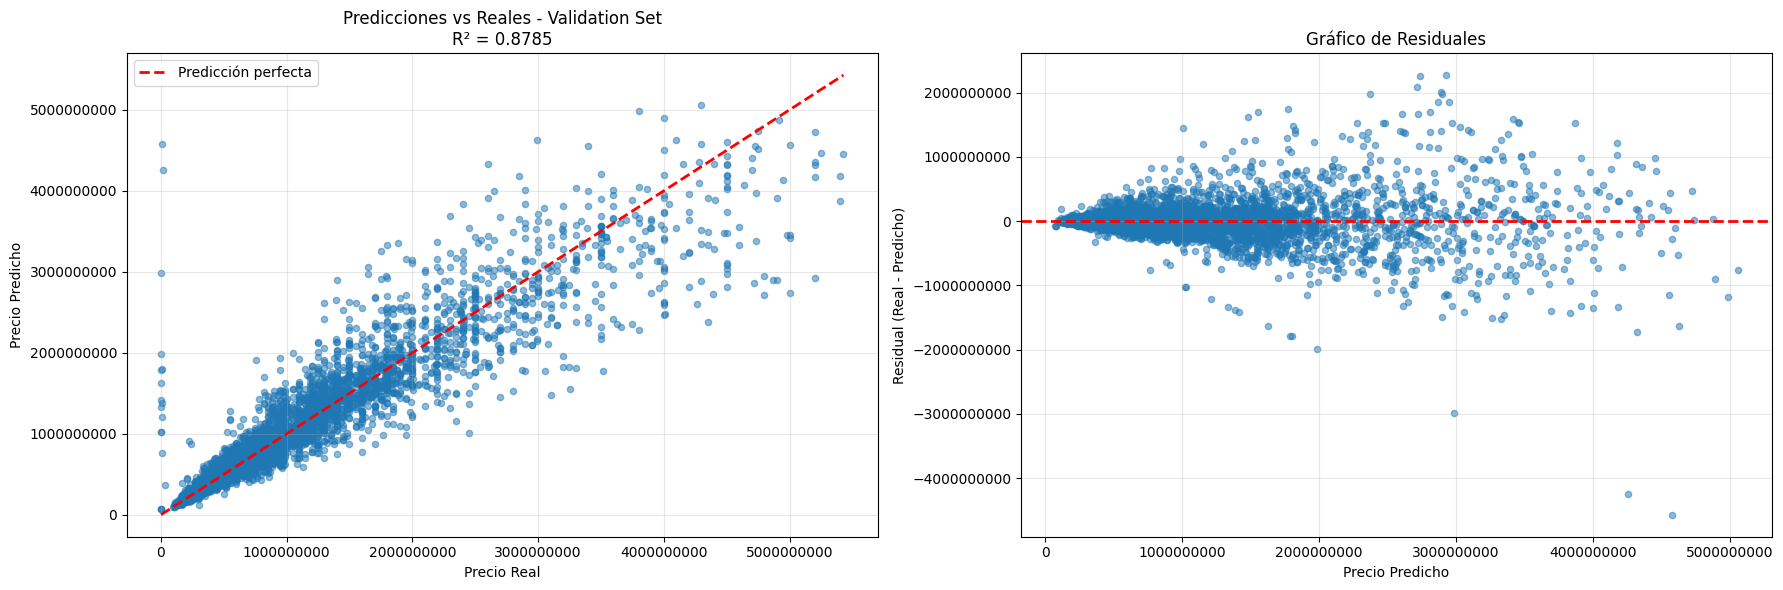

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# --- Predicciones vs Reales ---
axes[0].scatter(y_validation, y_validation_pred, alpha=0.5, s=20)
axes[0].plot([y_validation.min(), y_validation.max()],
             [y_validation.min(), y_validation.max()],
             'r--', lw=2, label='Predicción perfecta')
axes[0].set_xlabel('Precio Real')
axes[0].set_ylabel('Precio Predicho')
axes[0].set_title(f'Predicciones vs Reales - Validation Set\nR² = {val_r2:.4f}')
axes[0].legend()
axes[0].grid(alpha=0.3)
axes[0].ticklabel_format(style='plain')

# --- Residuales ---
residuals = y_validation - y_validation_pred
axes[1].scatter(y_validation_pred, residuals, alpha=0.5, s=20)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Precio Predicho')
axes[1].set_ylabel('Residual (Real - Predicho)')
axes[1].set_title('Gráfico de Residuales')
axes[1].grid(alpha=0.3)
axes[1].ticklabel_format(style='plain')

plt.tight_layout()
plt.show()

In [27]:
errores = y_test.values - y_validation_pred
UMBRAL = 20_000_000

subestimaciones_criticas = (errores < -UMBRAL).sum()
subestimaciones_aceptables = ((errores >= -UMBRAL) & (errores < 0)).sum()
predicciones_precisas = ((errores >= 0) & (errores <= UMBRAL)).sum()
sobreestimaciones = (errores > UMBRAL).sum()

total = len(errores)

resultados = pd.DataFrame({
    "Categoria": [
        "Subestimaciones críticas",
        "Subestimaciones aceptables",
        "Predicciones precisas",
        "Sobreestimaciones"
    ],
    "Cantidad": [
        subestimaciones_criticas,
        subestimaciones_aceptables,
        predicciones_precisas,
        sobreestimaciones
    ],
    "Porcentaje": [
        f"{subestimaciones_criticas/total*100:.2f}%",
        f"{subestimaciones_aceptables/total*100:.2f}%",
        f"{predicciones_precisas/total*100:.2f}%",
        f"{sobreestimaciones/total*100:.2f}%"
    ]
})

print(f"\nErrores en {total} predicciones (umbral ±20M):\n")
print(resultados.to_string(index=False))
print(f"\n{(total - subestimaciones_criticas)/total*100:.1f}% no necesitan avalúo presencial")


Errores en 5308 predicciones (umbral ±20M):

                 Categoria  Cantidad Porcentaje
  Subestimaciones críticas      2281     42.97%
Subestimaciones aceptables       573     10.80%
     Predicciones precisas       511      9.63%
         Sobreestimaciones      1943     36.61%

57.0% no necesitan avalúo presencial


## Conjunto de validación

In [16]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Se hizo la busqueda de hiperparámetros en otra ejecución durante el desarrollo de los modelos y se redujo en esta iteración solamente a sus valores finales ya optimizados. Esto permite concentrarse en la comparación directa del desempeño de los algoritmos sin volver a explorar los hiperparámetros, garantizando además que cada modelo se evalúe en condiciones estables y reproducibles.

In [17]:
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=5, shuffle=True, random_state=42)

modelos = {
    "Regresión Lineal": LinearRegression(),
    "Árbol de Decisión": DecisionTreeRegressor(max_depth=8, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=300, max_depth=12, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=8, random_state=42),
    "KNN": KNeighborsRegressor(n_neighbors=5)
}

resultados = []
pipes = {}

for nombre, modelo in modelos.items():

    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("model", modelo)
    ])

    scores = cross_val_score(pipe, X_train_full, y_train_full,
                             cv=kf, scoring="r2")

    resultados.append({
        "Modelo": nombre,
        "CV_R2_mean": scores.mean(),
        "CV_R2_std": scores.std()
    })

    pipes[nombre] = pipe

resultados_df = pd.DataFrame(resultados).sort_values("CV_R2_mean", ascending=False)
print(resultados_df)

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: F

              Modelo  CV_R2_mean  CV_R2_std
3            XGBoost    0.883013   0.005558
2      Random Forest    0.876682   0.004899
1  Árbol de Decisión    0.828186   0.004489
4                KNN    0.827429   0.007973
0   Regresión Lineal    0.696571   0.005992


In [28]:
best_model_name = resultados_df.iloc[0]["Modelo"]
print("Mejor modelo según CV:", best_model_name)

best_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", modelos[best_model_name])
])

# entrenar con TODO train_full
best_pipe.fit(X_train_full, y_train_full)

# evaluar con test
y_test_pred = best_pipe.predict(X_test)

print("TEST R²:", r2_score(y_test, y_test_pred))
print("TEST MAE:", mean_absolute_error(y_test, y_test_pred))
print("TEST RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))


Mejor modelo según CV: XGBoost
TEST R²: 0.878461863431142
TEST MAE: 162163906.34419745
TEST RMSE: 309824292.0992511


Comparando con validation, podemos ver que no hay overfitting, dado que los valores son muy similares con test.

Validation: 0.883013

Test: 0.878461

## Interpretabilidad

### LIME

In [32]:
# extraer preprocessor del mejor modelo
prep = best_model.named_steps["preprocessor"]

# nombres OHE
ohe = prep.named_transformers_["cat"]
cat_final = ohe.get_feature_names_out(categoricas)

# nombres finales en el orden exacto en que el modelo los ve
feature_names = np.concatenate([cat_final, numericas])

In [33]:
from lime.lime_tabular import LimeTabularExplainer

X_train_t = prep.transform(X_train)
X_val_t   = prep.transform(X_val)

explainer = LimeTabularExplainer(
    X_train_t,
    feature_names=feature_names,
    mode="regression"
)

i = 5
exp = explainer.explain_instance(
    X_val_t[i],
    best_model.named_steps["model"].predict
)

exp.show_in_notebook()


Explica una predicción puntual del modelo (es decir, una vivienda específica). Aproxima el modelo real con un modelo lineal simple alrededor de ese punto.

Cómo funciona?
- toma una viviendo específica que quieres explicar
- genera variaciones de esa vivienda
- revisar cómo cambia la predicción del modelo
- ajustar un modelo lineal simple para explicar esa predicción local
- "para esta predicción, tal y tal feature fueron los que subieron/bajaron el valor del precio"

Revisión por variable:
- area tiene un efecot positivo fuerte, es decir, el tamaño (en metros cuadrados) del lugar sube significativamente su precio.
- adminisitracion también tiene un efecto positivo grande, es decir, un valor de administración alto aumenta el precio del lugar.
- banos_5.0, parqueaderos_4.0, habitaciones_4.0 también efectos positivos (tener 5 baños, 4 parqueaderos y 4 habitaciones)
- latitud negativo, es decir, el lugar ubicado en esa latitud desminuye significativamente el valor del mismo. Acá también se puede ver la longitud, que tiene un efecto positivo muy pequeño.
- variables como 3 o 5 habitaciones no afectan el precio.
- el valor de estrato 6 no afecta signifivativamente por si solo, lo más probable porque está "incluido" en los valores de administraciones altas y áreas grandes.

### SHAPLEY

In [34]:
prep = best_model.named_steps["preprocessor"]

# columnas categóricas one-hot
ohe = prep.named_transformers_["cat"]
cat_features = ohe.get_feature_names_out(categoricas)

# columnas numéricas (ya escaladas pero mantienen nombre)
num_features = numericas

# concatenar en el orden correcto
feature_names = np.concatenate([cat_features, num_features])

In [35]:
import shap

X_train_t = prep.transform(X_train)
X_val_t   = prep.transform(X_val)

model = best_model.named_steps["model"]

In [36]:
X_train_t = prep.transform(X_train)
X_val_t   = prep.transform(X_val)

# convertir sparse → dense y asegurar tipo numérico
X_train_t = np.array(X_train_t.todense(), dtype=np.float32)
X_val_t   = np.array(X_val_t.todense(), dtype=np.float32)

model = best_model.named_steps["model"]

explainer = shap.TreeExplainer(model)
shap_values = explainer(X_val_t)

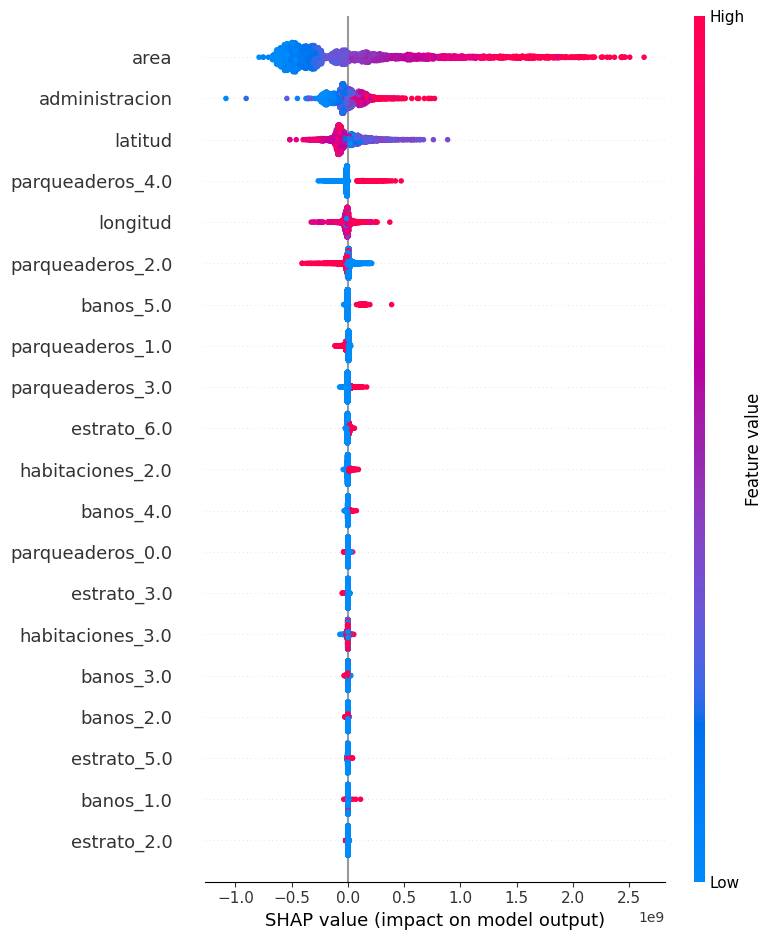

In [37]:
shap.summary_plot(shap_values, X_val_t, feature_names=feature_names)

Cada feature recibe un valor de contribución hacia arriba o abajo de la predicción. Da explicaciones globales y locales.

Aunque antes era de forma local, ahora con SHAP global vemos un comportamiento similar a LIME.
Los valores altos de area afectan positivamente a la variable objetivo, igual que valores altos de administracion.
Valores altos de latitud afectan negativamente y valores bajos positivamente. Tiene sentido, dado que hay zonas conocidamente caras (Chapinero alto, rosales, etc.) que tienen latitud más baja que el norte de la ciudad.
Tener 4 parqueaderos también se asocia fuertemente con precios altos
Y, de la misma forma que LIME, 5 baños también afecta positivamente, aunque en menor medida.

Valor real: 3100000000.0
Valor predicho: 2602105910.0076056


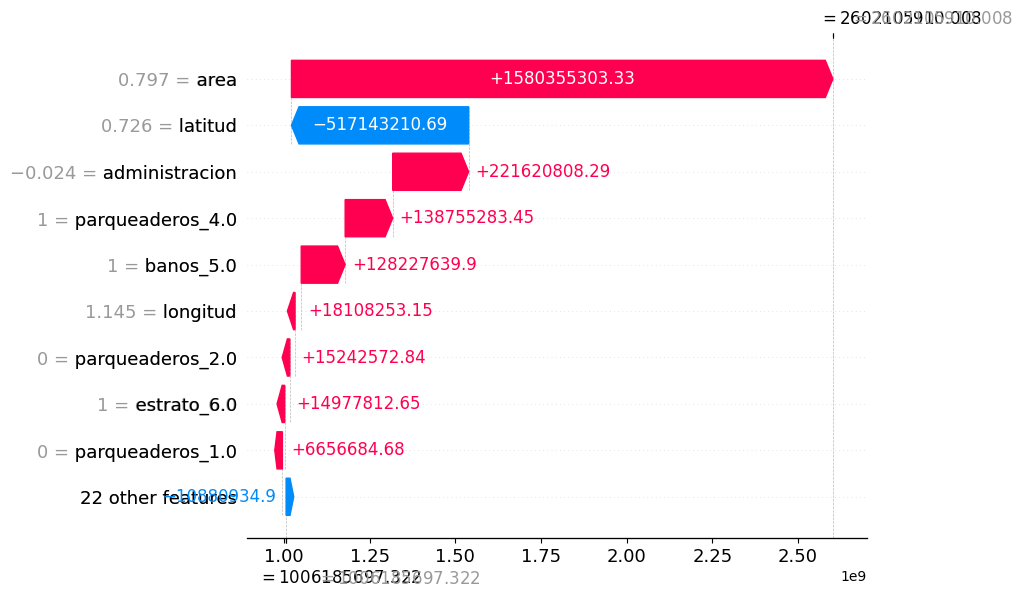

In [38]:
sample_index = 5
print("Valor real:", y_val.to_numpy()[sample_index])
print("Valor predicho:", y_val_pred[sample_index])

shap_values.feature_names = feature_names
shap.plots.waterfall(shap_values[sample_index])

Para esta predicción local, podemos ver resultados similares a los vistos usando LIME. Por un lado, el área vuelve a ser la variable que ejrce el efecto positivo más fuerte. De forma similar, la administración también contribuye positivamente. Entre las variables categóricas, se destacan impactos positivos importantes como parqueaderos\_4.0 y banos\_5.0, lo que indica nuevamente que contar con cuatro parqueaderos o cinco baños aumenta significativamente el precio predicho. La diferencia con LIME es la aparición de variables categóricas como parqueaderos\_2.0 o parqueaderos\_1.0. Estas muestran contribuciones positivas moderadas, mientras que otras variables más pequeñas aparecen agrupadas y no modifican sustancialmente la predicción final.